# Structural health monitoring

In this notebook we are going to be starting to think about how we might use the Hawk data to inform a structural health monitoring scheme. Our main aim is to explore features of the data that are going to be sensitive to the presence of damage in the structure. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import mahalanobis
import hawk

plt.rcParams['savefig.dpi'] = 300
sns.set_theme("paper")
sns.set_style("ticks")
sns.set_palette("Set2")

data_dir = "./hawk_data"  # use your cached data if you have it downloaded from previous notebooks
data = hawk.SBW(data_dir)
ws = data["/LMS/xData/freq"][:]

# control wether figs should be saved
save = True
save_dir = './figures/'

As a first step, lets take only the natural frequency values from the data and explore them with a straightforward RFP approach using the ranges that we defined previously.

In [3]:
# Recalling our RFP implementation from last episode...

# Hermitian transpose
def HT(a):
    return a.conj().T

# Rational fraction polynomial model
def RFP(H, w, n_modes, oob_terms=0):
    # Specify the orders of our approximation
    m = 1 + (n_modes * 2) + oob_terms # number of coefficients in the numerator polynomial
    n = 1 + (n_modes * 2)  # number of coefficients in the denominator polynomial

    # Build monomial basis matricies
    Phi_a = (1j*w[:, None]) ** np.arange(m) 
    Phi_b = (1j*w[:, None]) ** np.arange(n) 

    P = Phi_a 
    T = Phi_b[:,:-1] * H[:, None]
    W = Phi_b[:, -1] * H
    PT = -HT(P)@T
    
    # form the block matricies
    M = np.block([[HT(P)@P, PT], [PT.T, HT(T)@T]])
    x = np.block([HT(P)@W, -HT(T)@W])

    # Solve and extract the coefficients of the polynomials
    AB = np.linalg.solve(np.real(M), np.real(x))
    a = AB[:m, None]
    b = np.append(AB[m:], 1)[:, None]

    # Generate the predicted FRF
    H_pred = (Phi_a @ a) / (Phi_b @ b)

    # Pull out the modal porperties
    roots_b = sorted(np.roots(np.flip(b[:, 0])))[::-2]  # remove every other because they are conj pairs   
    wns = np.abs(roots_b)
    zetas = -np.real(roots_b) / wns
    return H_pred, wns, zetas

def get_wns(ranges, ws, frf, oob=6):
    wns = []
    for (low, high), n in ranges:
        idx = np.logical_and(ws > low, ws < high)
        _, wn, _ = RFP(frf[idx], ws[idx], n, oob_terms=oob)
        wns.extend(wn)
    return np.array(wns)

In [4]:
# Extracting the nartural frequencies

### You should experiment with these:
baseline_test = "BR_AR"
damage_locs = ["DS_TLE", 'DS_RLE', 'DS_CTE']
sensors = hawk.misc.all_sensors - {'FRC', 'EXH'}
ranges = (
    ((5, 9), 1),
    ((12, 14), 1),
    ((15, 19), 1),
    ((22, 24), 2),
    ((26, 30), 1),
    ((30.5, 31), 1),
    ((35, 37), 1),
    ((40.5, 44), 2),
    ((48.5, 54), 2),
    ((86, 90), 1),
    ((92, 100), 1),
    ((112, 118.5), 1),
    ((119.5, 122), 1),
    ((122, 125), 1),
    ((135, 138), 1),
    ((154, 162), 1),
)
###


all_wns_averaged = []  # Avereged accross sensor locations
all_damage_weights = []
all_excitation_levels = []
all_damage_locs = []

for series in [baseline_test, *damage_locs]:
    for test in data[f'/LMS/{series}'].values():
        meta = test.describe()
        for i in range(10):
            wns = np.array([get_wns(ranges, ws[:], test[f'{sensor}/frf'][:, i]) for sensor in sensors])

            all_wns_averaged.append(wns.mean(0))
            all_damage_weights.append(float(meta["addedMassg"]))
            all_excitation_levels.append(float(meta["excitationLevelV"]))
            all_damage_locs.append(series.split('_')[-1])

(320, 19)

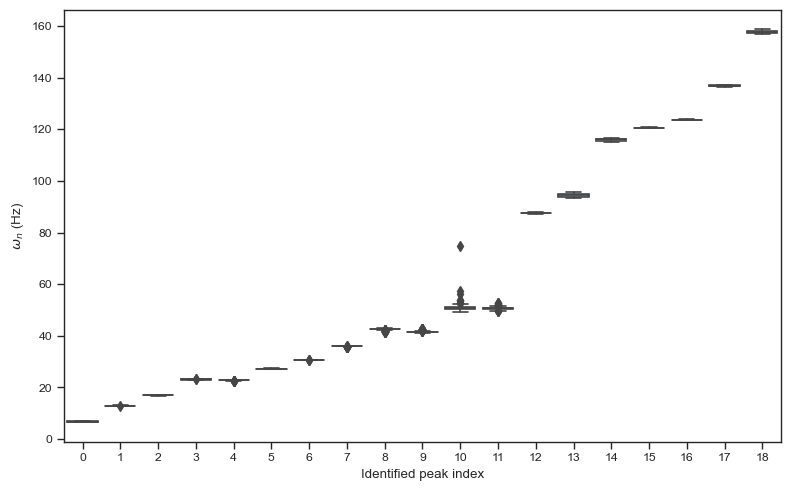

In [5]:
# Exploring the outliers in the data

plt.figure(figsize=(8, 5))
sns.boxplot(np.array(all_wns_averaged))
plt.xlabel("Identified peak index")
plt.ylabel(r"$\omega_n$ (Hz)")
plt.tight_layout()
if save:
    plt.savefig(save_dir+'wns_boxplot.png')

np.array(all_wns_averaged).shape

In [6]:
# remove the 10th mode from the PCA
all_wns_averaged = np.delete(all_wns_averaged, [10], axis=1)

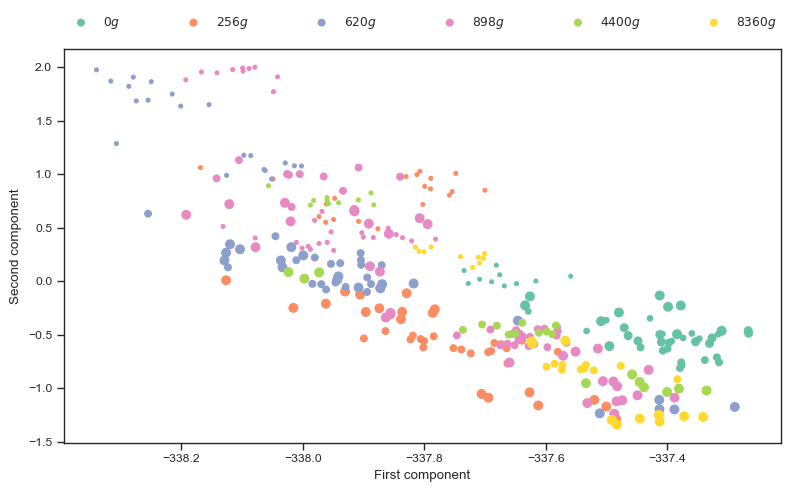

In [7]:
# Take PCA of the natural frequencies
U, s, V = np.linalg.svd(all_wns_averaged, full_matrices=0)
PCS = U @ np.diag(s)

# Plotting the first 2 principal components
weights = np.unique(all_damage_weights)
plt.figure(figsize=(8, 5))
for i, w in enumerate(weights):
    idx = np.array(all_damage_weights) == w
    plt.scatter(
        PCS[idx, 0],
        PCS[idx, 1],
        c=[f"C{i}"] * sum(idx),
        s=np.array(all_excitation_levels)[idx] * 20,
        label=f"${int(w)}g$",
    )
plt.legend(
    bbox_to_anchor=(0, 1.1, 1, 0),
    loc="upper left",
    ncols=6,
    mode="expand",
    borderaxespad=0,
    frameon=False,
)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.tight_layout()
if save:
    plt.savefig(save_dir+'wns_PCA.png')

In [8]:
def GMM(train_idx, features, labels, fmt, figname=''):
    labels = np.array(labels)
    labs = np.unique(labels[train_idx])

    mus = np.zeros((len(labs), features.shape[1]))
    covs = np.zeros((len(labs), features.shape[1], features.shape[1]))
    lower_inv = np.zeros((len(labs), features.shape[1], features.shape[1]))
    dets = np.zeros(len(labs))
    ws = np.zeros(len(labs))

    for i, lab in enumerate(labs):
        idx = labels[train_idx] == lab
        mus[i] = np.mean(features[train_idx][idx], 0)
        covs[i] = np.cov(features[train_idx][idx].T)
        lower = np.linalg.cholesky(covs[i])
        lower_inv[i] = np.linalg.inv(lower)
        dets[i] = np.sum(np.log(np.diag(lower)))
        ws[i] = sum(idx) / len(idx)

    pred_labs = []
    for x in features:
        rh_sq = np.array(
            [lower_inv[i, :, :].dot(x - mus[i, :]) for i in range(mus.shape[0])]
        )
        sq_term = (rh_sq**2).sum(1)
        ll = -dets - 0.5 * sq_term + np.log(ws)
        pred_labs.append(labs[np.argmax(ll)])
    pred_labs = np.array(pred_labs)


    # plots
    plt.figure(figsize=(8, 5))
    plt.scatter(*features[train_idx].T, c=f"k", s=50, marker="x", alpha=0.2, label="Training")
    for i, lab in enumerate(labs):
        plt.scatter(*features[labels==lab].T, c=f"C{i}", s=30, label=fmt(lab)) # True labels
        plt.scatter(*features[pred_labs==lab].T, c=f"C{i}", s=5) # Predicted labels
        # Plot Ellipses
        vals, vecs = np.linalg.eig(covs[i])
        plt.gca().add_artist(
            Ellipse(
                mus[i],
                *2 * 2 * np.sqrt(vals),
                angle=np.degrees(np.arctan2(*vecs[:, 0][::-1])),
                edgecolor=f"C{i}",
                facecolor="none",
                lw=1,
            )
        )
    plt.legend(
        bbox_to_anchor=(0, 1.1, 1, 0),
        loc="upper left",
        ncols=len(labs) + 1,
        mode="expand",
        borderaxespad=0,
        frameon=False,
    )
    plt.xlabel("First component")
    plt.ylabel("Second component")
    plt.tight_layout()
    if save:
        plt.savefig(save_dir+f'GMM_{figname}.png')

    # Confusion matrix
    confusion = np.zeros((len(labs), len(labs)))
    for i, true in enumerate(labs):
        for j, pred in enumerate(labs):
            idx = (labels==true) * (pred_labs==pred)
            confusion[i, j] = sum(idx)

    plt.figure()
    ax = sns.heatmap(confusion.T.astype(int), xticklabels=labs, yticklabels=labs, annot=True, cmap='crest', fmt='d')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    if save:
        plt.savefig(save_dir+f'GMM_confusion_{figname}.png')

    return pred_labs


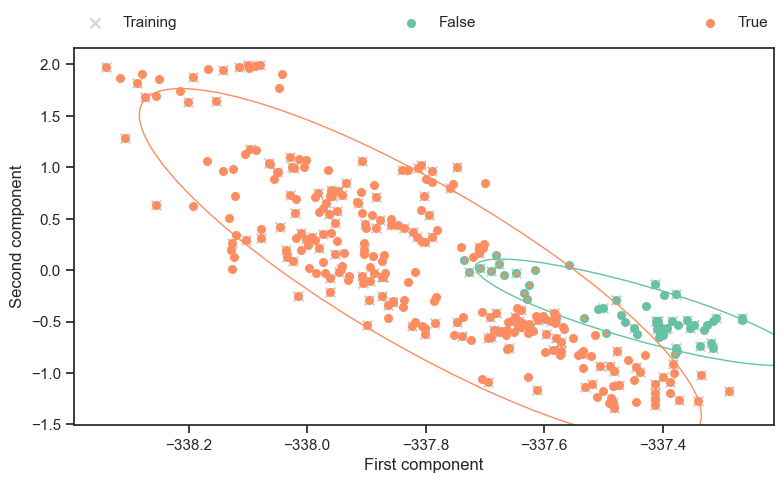

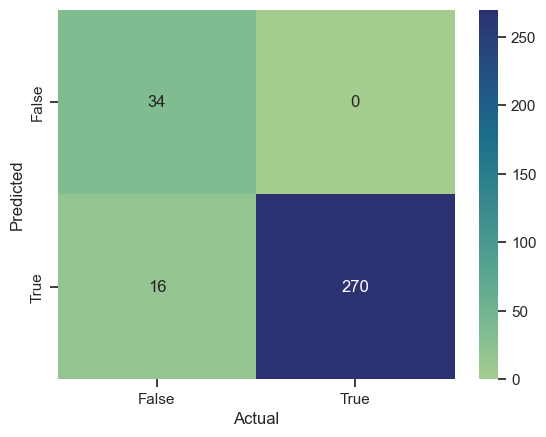

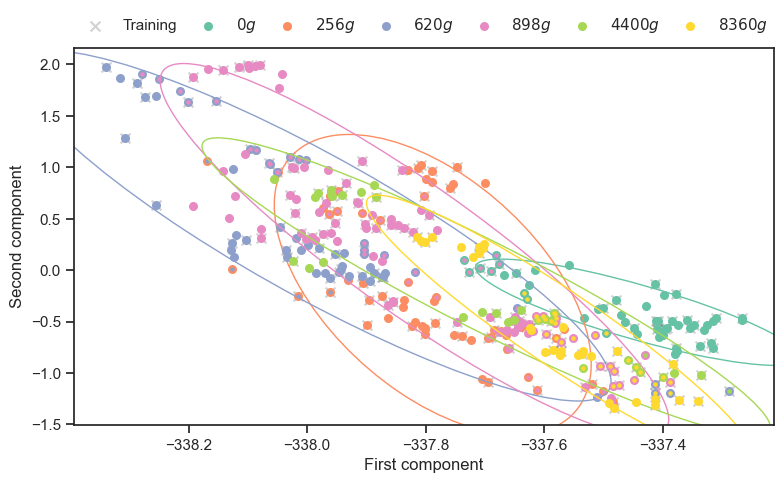

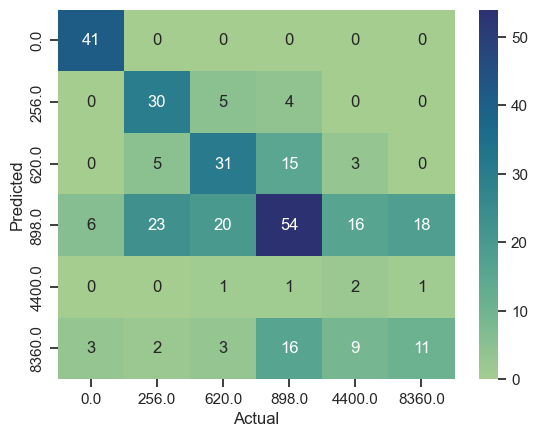

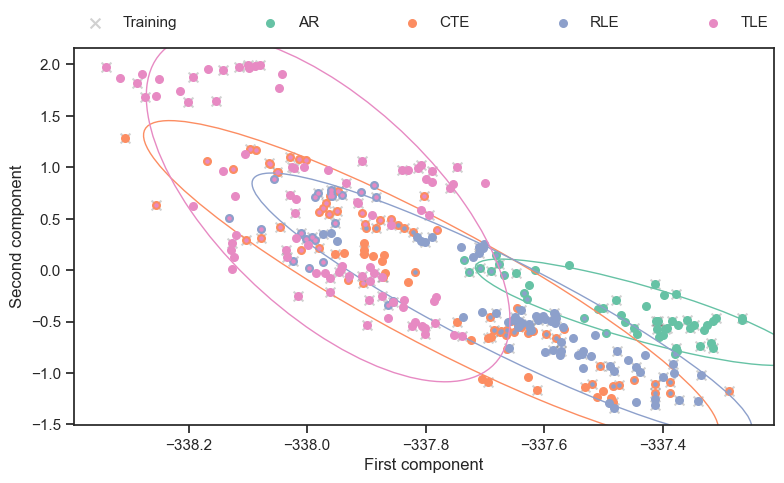

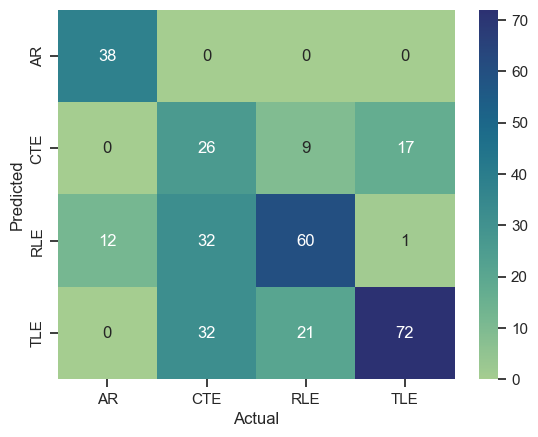

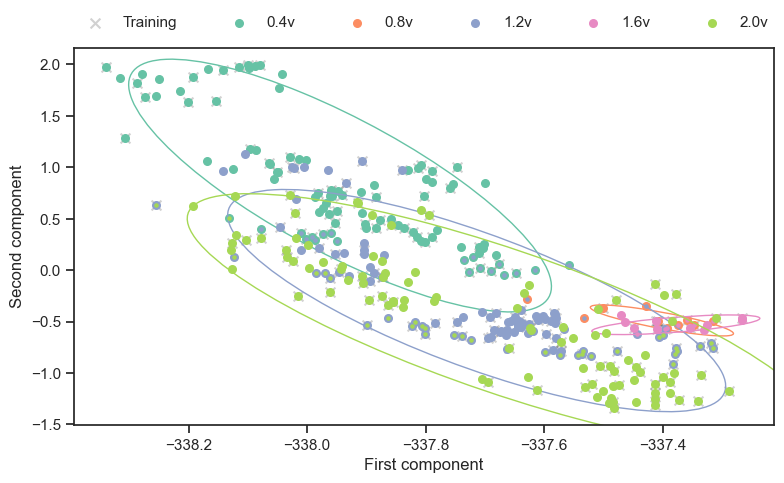

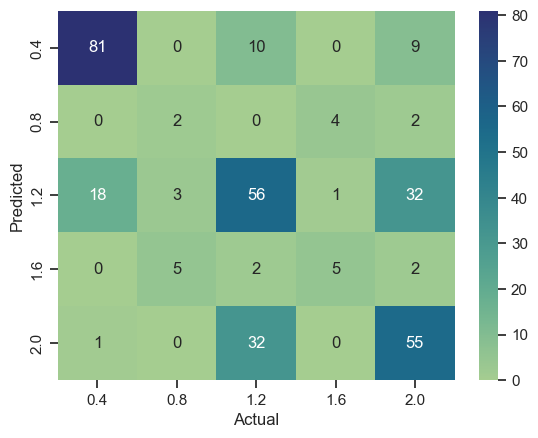

In [9]:

train_idx = np.ones(PCS.shape[0], dtype=bool)
train_idx[::2] *= False  # use every other point for training
sns.set_theme("notebook")
sns.set_style("ticks")
sns.set_palette("Set2")
pred = GMM(train_idx, PCS[:, :2], np.array(all_damage_weights) > 0,lambda d:f'{d}', figname='damage')  # presence of damage
pred = GMM(train_idx, PCS[:, :2], np.array(all_damage_weights)    ,lambda d:f'${int(d)}g$', figname='damage_weight')      # extent of damage
pred = GMM(train_idx, PCS[:, :2], np.array(all_damage_locs)       ,lambda d:f'{d}', figname='damage_loc')         # location of damage
pred = GMM(train_idx, PCS[:, :2], np.array(all_excitation_levels) ,lambda d:f'{d}v', figname='excitaion')   # excitation level

Overall, we have seen that the natural frequencies do appear to be sensitive to damage. However, if we do not remove the outliers then the variance in the data can become dominated by the quality of our firring algorithm, which is not what we want!

In the next section we will look at using the specral lines themselves as features in a damage detection algorithm.


### Damage detection

Often the initial task when developing a structural health monitoring strategy is to be able to assess whether damage is present in the structure or not. Generally, this task is referred to as damage detection. 

In this notebook, we're going to look at how we can approach the task of damage detection through outlier analysis. If we believe that the data we acquire from our structure will change in some way as damage develops, then we can begin by using data that has been collected from our structure in a known undamaged state to form a baseline. As we continue to monitor our structure online where we lack prior knowledge of the damage state (e.g. damage label is now a latent state), then we can evaluate how similair our new data are to the baseline as an indication of whether we believe damage is present or not.

To assess this similairty (or to be more exact, dissimilarity), we can use a measure of novelty. If outliers begin to appear, then this can inform us about potential damage.

To begin, let's load in data from both an undamaged and damaged test series. The data representing our undamaged state is from the test series "BR_AR", whilst the data representing the damage state is taken from the test series "DS_TLE". As you may have already seen, damage is simulated through the addition of added mass at various locations on the wing. 

Before we can think about whether our structure is damaged or not, we need to think about damage sensitive features - simply put, what type of data can we collect that is going to tell us about damage growth in the structure. In SHM, we often have access to lots of physically meaningful features, such as natural frequencies, which you'll have seen in earlier notebooks. 

In this notebook, we're going to look at frequency response functions of the structure as our damage sensitive feature. 

Note - when running the code block below yourself, you'll need to set directory for downloaded data.

In [10]:
# Extracting the nartural frequencies

### You should experiment with these:
baseline_test = "BR_AR"
damage_locs = ["DS_TLE", 'DS_RLE', 'DS_CTE']
sensors = ['ULC-03']
###

all_frfs = []  # Avereged accross sensor locations
all_damage_weights = []
all_excitation_levels = []
all_damage_locs = []

for series in [baseline_test, *damage_locs]:
    for test in data[f'/LMS/{series}'].values():
        meta = test.describe()
        for sensor in sensors:
            for rep in range(10):
                all_frfs.append(test[f'{sensor}/frf'][:, rep])
                all_damage_weights.append(float(meta["addedMassg"]))
                all_excitation_levels.append(float(meta["excitationLevelV"]))
                all_damage_locs.append(series.split('_')[-1])

np.array(all_frfs).shape

(320, 8193)

We get two useful outputs from this code block:
<br />
<br />
- out: dictionary relating test ID to its frequency response values, input signal amplitude of the test, and damage level (in the case of damage state data)
<br />
- freqs: frequencies corresponding to the FRF

Let's look at the FRF for one of the undamaged tests, and one of the damaged

2.0
898.0


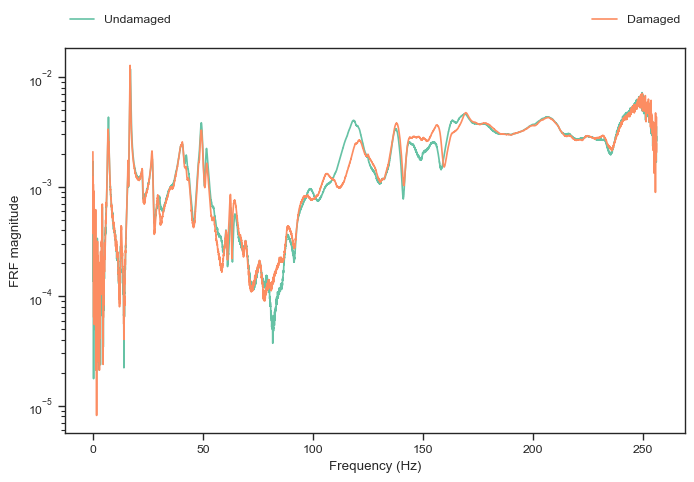

In [18]:
sns.set_theme("paper")
sns.set_style("ticks")
sns.set_palette("Set2")
plt.figure(figsize=(8, 5))
plt.semilogy(ws,np.abs(data['/LMS/BR_AR/05/ULC-03/frf'][:].mean(1)),label = 'Undamaged')
plt.semilogy(ws,np.abs(data['/LMS/DS_TLE/09/ULC-03/frf'][:].mean(1)), label = 'Damaged')
plt.xlabel('Frequency (Hz)')
plt.ylabel('FRF magnitude')
plt.legend(
    bbox_to_anchor=(0, 1.1, 1, 0),
    loc="upper left",
    ncols=2,
    mode="expand",
    borderaxespad=0,
    frameon=False,
    )
if save:
    plt.savefig(save_dir+f'frf_comp_1.png')
print(data['/LMS/BR_AR/05/ULC-03/frf'].describe()['excitationLevelV'])
print(data['/LMS/DS_TLE/09/ULC-03/frf'].describe()['addedMassg'])

Notice the shift in both peak frequencies and amplitudes in the damage case relative to the undamaged. This tells us we have a suitable damage sensitive feature. 

Now, although we've now seen that the FRF is sensitive to damage, using the entire FRF would mean an 8192 dimensional feature vector. We can be a bit more clever, and focus on just one peak (e.g. a natural frequency) of the FRF plot that is sensitive to damage. For instance, if we zoom into ~ 156Hz


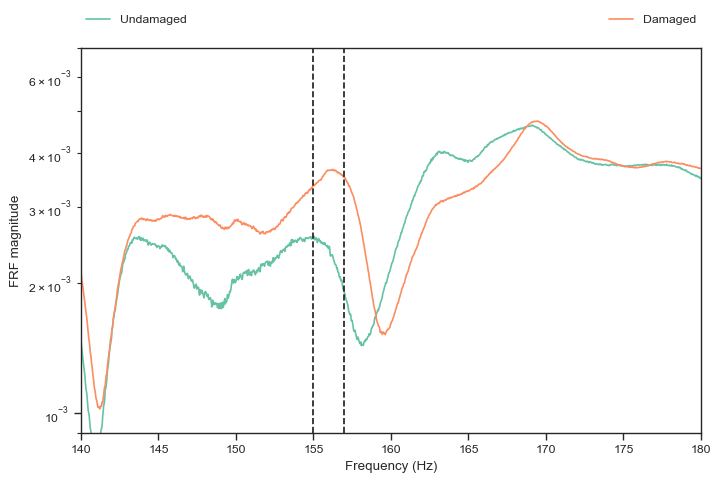

In [12]:
sns.set_theme("paper")
sns.set_style("ticks")
sns.set_palette("Set2")
plt.figure(figsize=(8, 5))
plt.semilogy(ws,np.abs(data['/LMS/BR_AR/05/ULC-03/frf'][:].mean(1)),label = 'Undamaged')
plt.semilogy(ws,np.abs(data['/LMS/DS_TLE/09/ULC-03/frf'][:].mean(1)), label = 'Damaged')
plt.xlabel('Frequency (Hz)')
plt.ylabel('FRF magnitude')
plt.legend(
    bbox_to_anchor=(0, 1.1, 1, 0),
    loc="upper left",
    ncols=2,
    mode="expand",
    borderaxespad=0,
    frameon=False,
    )
plt.axvline(x=155, c='k', ls='--')
plt.axvline(x=157, c='k', ls='--')
plt.xlim([140,180])
plt.ylim([9e-4, 7e-3])
if save:
        plt.savefig(save_dir+f'frf_comp_2.png')


In just this narrow region, we can still see a shift in the behaviour of the FRF. 

Taking 8 spectral lines (e.g 8 discrete freqeuncy values) as our feature vector, we can now begin our outlier analysis.

In [13]:
start_idx = int(np.where(ws==155)[0])
end_idx = int(np.where(ws==157)[0])
interval = 8

all_features = np.abs(np.array(all_frfs)[:, start_idx:end_idx:interval])

In [14]:
def outlier_analysis(train_idx, test_idx, all_features, all_labels, CI, fmt, figname):
    train = all_features[train_idx]
    test  = all_features[test_idx]
    all_labels = np.array(all_labels)
    labels = np.concatenate([all_labels[train_idx], all_labels[test_idx]])
    # Compute threshold (MC for the thrshold given a CI)
    n, p = train.shape
    N = 1000
    max_D = np.zeros((N,))
    for i in range(0, N):
        X = np.array(np.random.randn(n, p))
        Xcov = np.cov(X.T)
        Xcov_inv = np.linalg.inv(Xcov)
        Xmean = np.mean(X, 0)
        D = np.zeros((n,))
        for j in range(0, n):
            D[j] = mahalanobis(X[j, :], Xmean, Xcov_inv)
        max_D[i] = np.max(D)
    D_sort = np.sort(max_D)
    idx = int(CI / (100 / N))
    threshold = D_sort[idx]
    # Compute training stats
    mu = np.mean(train, 0)
    cov = np.cov(train.T)
    cov_inv = np.linalg.inv(cov)
    # Compute the novelty indicies of all the data
    data = np.concatenate([train, test])
    idxs = np.arange(len(data))
    novelty = np.array([mahalanobis(row, mu, cov_inv) for row in data])
    # Finally plot
    plt.figure(figsize=(8, 5))
    damage_types = np.unique(labels)
    for i, d in enumerate(damage_types):
        idx = labels == d
        plt.scatter(idxs[idx], novelty[idx], c=f"C{i}", label=fmt(d))
    plt.gca().axhline(threshold, c="k", ls="--")
    plt.gca().axvline(len(train), c="k", ls="--")
    plt.legend(
    bbox_to_anchor=(0, 1.1, 1, 0),
    loc="upper left",
    ncols=len(damage_types),
    mode="expand",
    borderaxespad=0,
    frameon=False,
    )
    plt.xlabel('Datapoint index')
    plt.ylabel('Novelty index')
    if save:
        plt.savefig(save_dir+f'Novelty_{figname}.png')


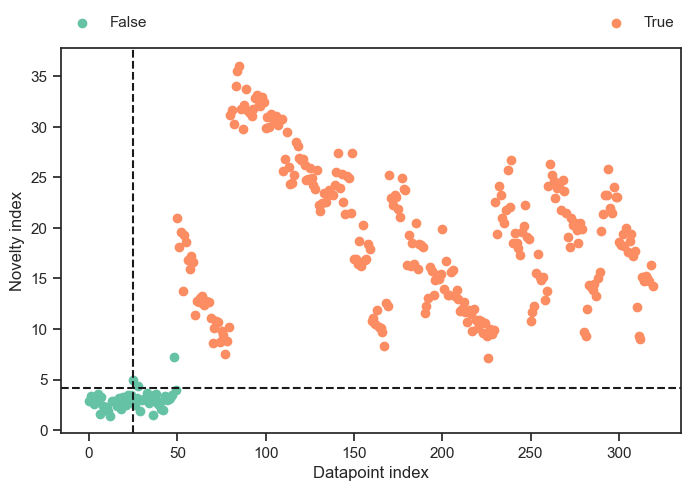

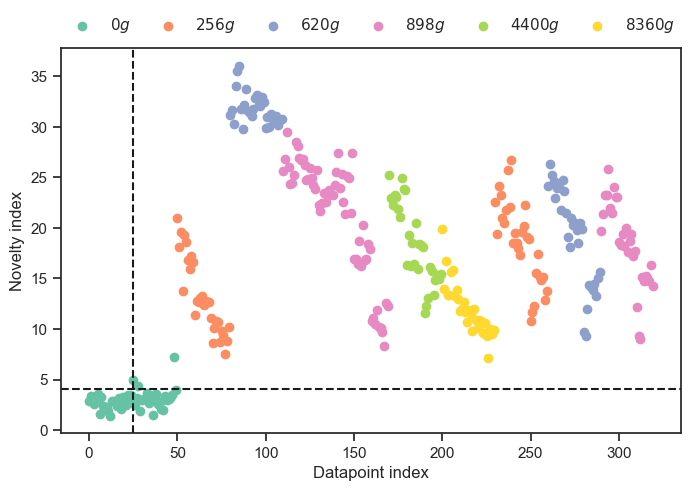

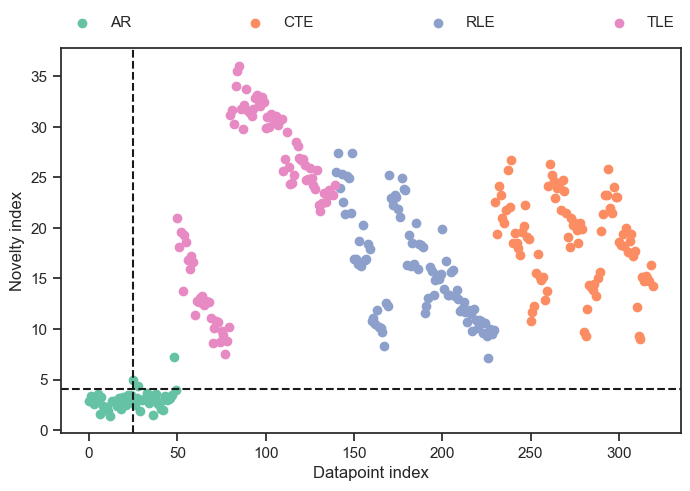

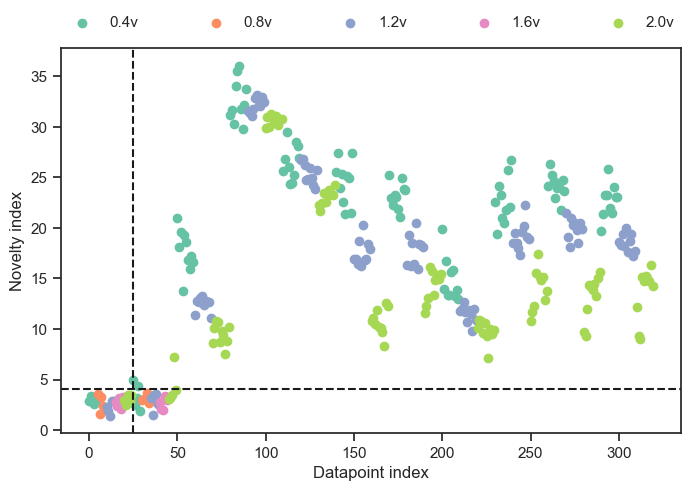

In [15]:
sns.set_theme("notebook")
sns.set_style("ticks")
sns.set_palette("Set2")
train = np.array(all_damage_weights)==0
train[::2] *= False
outlier_analysis(train, ~train, all_features, np.array(all_damage_weights)>0, 95, lambda d:f'{d}', 'damage')
outlier_analysis(train, ~train, all_features, all_damage_weights, 95,             lambda d:f'${int(d)}g$', 'damage_weight')
outlier_analysis(train, ~train, all_features, all_damage_locs, 95,                lambda d:f'{d}', 'damage_loc')
outlier_analysis(train, ~train, all_features, all_excitation_levels, 95,          lambda d:f'{d}v', 'excitation')


The first case we'll look at is where we have reference data for a range of undamaged data (with different input signal amplitudes), with damage data only from the most "severe" damage case. In this instance, this means maximum mass at the tip of the wing.

For our novelty measure, we're going to use the mahalanobis distance. 

On the plot, the horizontal line represents the novelty threshold (e.g above the line is an outlier), and the vertical line represents the end of the reference/training data. 

We can see that the novelty detector is easilly able to distinguish being data originating from the undamaged and damaged condition. However, given that we're training entirely on undamaged data, and using data from the most severe damage, this isn't perhaps too suprising. 

Let's try a slightly more challenging scenario... use the same data as above to form the reference data, whilst using a range of tests from the undamaged and damage states. 

We can see now that the results are not so clear cut, with a number of false positives (undamage instances classed as novel) now emerging. Have a think about what you think is making some of the undamage data points more novel than others. Rather encouragingly, however, is that all of the damage data are classed as novel.  

As a final example, let's load in another test series, DS_RLE, which corresponds to added mass at the root of the hawk wing. As the additional mass is now much closer to the fixed point of the wing that at the tip, it may prove harder to identify shifts in the FRF.

Let's take a look at the FRF for one of the DS_RLE tests, and the BR_AR (no damage) test that we looked at earlier.

ALthough the damage in RLE causes some change in the FRF, it is not as prominent of a change as the earlier damage location (TLE).


Although the outlier detection has done reasonably well at indicating the presence of damage, what we've considered here is just the tip of the iceberg! We've looked at the case where we have access to data that we believe to be from an undamaged state, and have then compared to simulated damage via the addition of mass. However, often we might not have prior access to data representative of undamaged conditions. In this scenario, maybe we'd like to adopt an online semi-supervised strategy, where we add labels to our data via inspections at times the algorithm determines there to be novelty. 

Another issue is that of confounding influences in the form of enviornmental and operational variation. Changes in temperature, wind loading conditions, traffic on a bridge (and so much more!) will all also cause changes in our data. However, as not representative of damage, we want to avoid our SHM algorithm flagging up these events as damage. 

Finally, we've only looked at the first stage of SHM; detection. As we move further up the SHM hiearachy, we encounter more involved tasks such as localisation, classification of damage type, and remaining useful life estimation. Whilst we get more insight into the damage on our structure by answering these questions, the challenge posed becomes much harder than detection alone. 